In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg 
from scipy.ndimage import gaussian_filter
from scipy import stats as st
import numpy as np
 

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
68,00000390_000.png,No Finding,0,390,021Y,F,PA,2048,2500,0.171,0.171
293,00001558_018.png,Atelectasis|Consolidation|Effusion,18,1558,055Y,M,AP,2500,2048,0.168,0.168
2778,00013917_038.png,Cardiomegaly|Effusion|Infiltration,38,13917,055Y,M,PA,2992,2991,0.143,0.143


### General Dataset Info

In [3]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


### Pivoting the Finding Labels into columns

In [5]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
27243,00007094_001.png,No Finding,1,7094,62,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67908,00016778_036.png,Infiltration|Mass,36,16778,26,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
53999,00013615_010.png,No Finding,10,13615,9,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Exploring Patient Data In Details

In [14]:
print("The full dataset has {} records".format(len(all_xray_df)))
print("There are {} findings of pneumonia which is only {:.2%} of the whole population".format(int(all_xray_df['Pneumonia'].sum()), all_xray_df['Pneumonia'].sum()/len(all_xray_df)))

The full dataset has 112120 records
There are 1431 findings of pneumonia which is only 1.28% of the whole population


In [6]:
all_xray_df['Patient Age'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 148, 149, 150, 151, 152, 153, 154, 155, 411,
       412, 413, 414])

In [8]:
age_df = pd.DataFrame()
age_df['Age'] = all_xray_df['Patient Age']
age_df['bins'] = pd.cut(age_df['Age'], bins=[1, 20, 40, 60, 80, 100,500],
                     labels=['1 to 20', '21 to 40', '41 to 60', 
                             '61 to 80', '81 to 100', '101 to 500'])
print(age_df.groupby('bins')['Age'].count().reset_index(name='counts'))

         bins  counts
0     1 to 20    7796
1    21 to 40   30143
2    41 to 60   49502
3    61 to 80   23766
4   81 to 100     881
5  101 to 500      16


We seem to have 16 patients with age greater than 100 years old. We probaly should remove them from training.

In [9]:
print("Total cases in the dataset: {} " .format(len(all_xray_df)))
print("Total cases with pneumonia in the dataset: {:.0f} " .format(all_xray_df.Pneumonia.sum()))
print("Total cases with no pneumonia in the dataset: {:.0f} " .format((len(all_xray_df)) - (all_xray_df.Pneumonia.sum())))

Total cases in the dataset: 112120 
Total cases with pneumonia in the dataset: 1431 
Total cases with no pneumonia in the dataset: 110689 


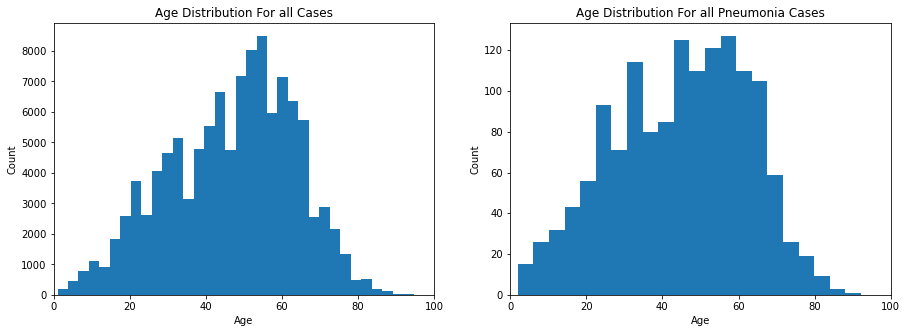

In [131]:
figure, (ax0,ax1) = plt.subplots(1,2, figsize = (15, 5))

ax0.hist(all_xray_df['Patient Age'], bins=150)
ax0.set_xlim(0,100)
ax0.set_xlabel("Age")
ax0.set_ylabel("Count")
ax0.set_title("Age Distribution For All Cases")


ax1.hist(all_xray_df[all_xray_df['Pneumonia'] == 1]['Patient Age'] , bins=100)
ax1.set_xlim(0,100)
ax1.set_xlabel("Age")
ax1.set_ylabel("Count")
ax1.set_title("Age Distribution For All Pneumonia Cases")

plt.show()

Most patients are in their 60's same with pneumonia patients.

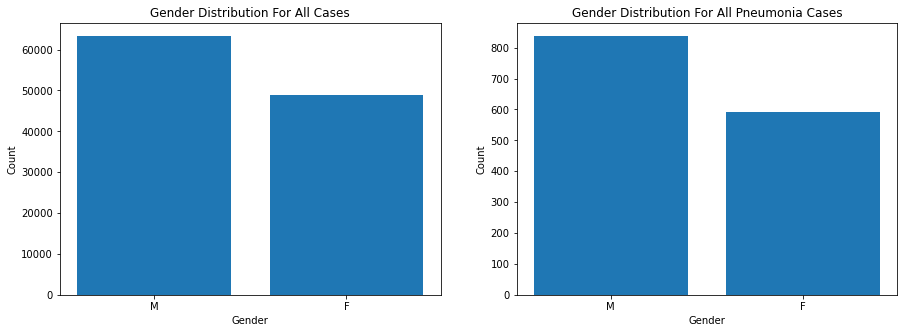

In [132]:
figure, (ax0,ax1) = plt.subplots(1,2, figsize = (15, 5))
all_gender_count=all_xray_df['Patient Gender'].value_counts()
p_gender_count=all_xray_df[all_xray_df['Pneumonia'] ==1]['Patient Gender'].value_counts()

ax0.bar(all_gender_count.index, all_gender_count)
ax0.set_title('Gender Distribution For All Cases')
ax0.set_xlabel('Gender')
ax0.set_ylabel('Count')

ax1.bar(p_gender_count.index, p_gender_count)
ax1.set_title('Gender Distribution For All Pneumonia Cases')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count')

plt.show()

Seems like the ratios for all cases and pneumonia cases are about the same for gender. Males seem to account more for both population sets.

In [134]:
all_xray_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

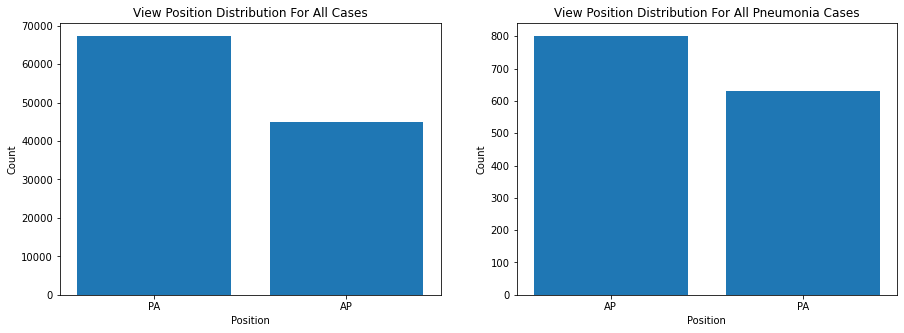

In [135]:
figure, (ax0,ax1) = plt.subplots(1,2, figsize = (15, 5))
all_vp_count=all_xray_df['View Position'].value_counts()
p_vp_count=all_xray_df[all_xray_df['Pneumonia'] ==1]['View Position'].value_counts()

ax0.bar(all_vp_count.index, all_vp_count)
ax0.set_title('View Position Distribution For All Cases')
ax0.set_xlabel('Position')
ax0.set_ylabel('Count')

ax1.bar(p_vp_count.index, p_vp_count)
ax1.set_title('View Position Distribution For All Pneumonia Cases')
ax1.set_xlabel('Position')
ax1.set_ylabel('Count')

plt.show()

PA seems to be the dominant view position for all cases, but AP seems to more used in pneumonia cases.

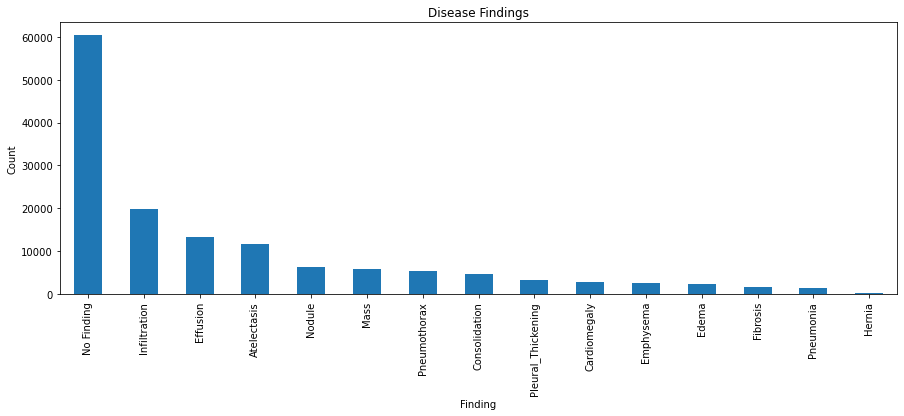

Finding              Count
========             =========
No Finding            60361.0
Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64


In [161]:
figure, ax = plt.subplots( figsize = (15, 5))
disease_count = all_xray_df[all_labels].sum().sort_values(ascending=False)
disease_count.plot(kind='bar')
ax.set_xlabel("Finding")
ax.set_ylabel("Count")
ax.set_title("Disease Findings")
plt.show()

print("Finding              Count")
print("========             =========")
print(disease_count)

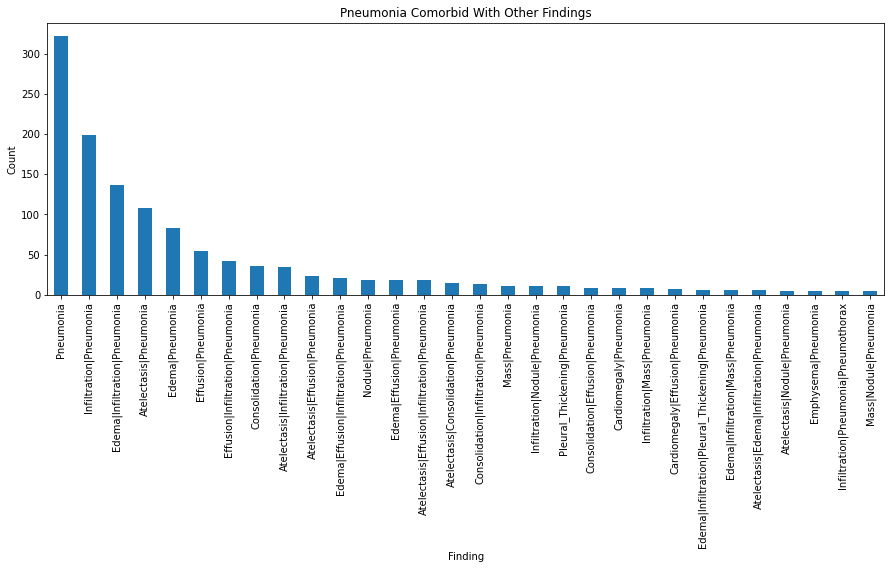

Top 15 Comorbid with pneumonia: 

Pneumonia                                      322
Infiltration|Pneumonia                         199
Edema|Infiltration|Pneumonia                   137
Atelectasis|Pneumonia                          108
Edema|Pneumonia                                 83
Effusion|Pneumonia                              54
Effusion|Infiltration|Pneumonia                 42
Consolidation|Pneumonia                         36
Atelectasis|Infiltration|Pneumonia              34
Atelectasis|Effusion|Pneumonia                  23
Edema|Effusion|Infiltration|Pneumonia           21
Nodule|Pneumonia                                19
Edema|Effusion|Pneumonia                        19
Atelectasis|Effusion|Infiltration|Pneumonia     18
Atelectasis|Consolidation|Pneumonia             15
Name: Finding Labels, dtype: int64


In [177]:

figure, ax = plt.subplots(figsize=(15,5))
pnemonia_comorbid =  all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()
pnemonia_comorbid[0:30].plot(kind='bar')
ax.set_title("Pneumonia Comorbid With Other Findings")
ax.set_ylabel("Count")
ax.set_xlabel("Finding")
plt.show()

print('Top 15 Comorbid with pneumonia: \n\n{}'.format(pnemonia_comorbid[0:15]))

The top 3 comorbid findings that occur frequently with Pneumonia are Infiltration, Atelectasis and Edema.

### Diseases Per Patient Considering All Scans

In [101]:
dpp = all_xray_df.copy()
dpp_all_labels = all_labels.copy()
dpp_all_labels.remove("No Finding")
dpp['disease_sub_total'] = dpp[dpp_all_labels].sum(axis=1)
all_d = dpp.groupby('Patient ID')['disease_sub_total'].sum().reset_index(name='col_disease_sum')
print("Number of disease per patient for scans captured over the years: {:.3f}" .format(all_d['col_disease_sum'].sum()/len(all_d)))
print("Number of disease per patient per scan {:.3f}" .format(all_d['col_disease_sum'].sum()/len(dpp)))


Number of disease per patient regardless of scans captured over the years: 2.635
Number of disease per patient per scan 0.724


Example below shows that patient, Patient ID 3, has multiple scans over the years. Thus the number of disease per patient would depend on the time-frame context.

In [102]:
all_xray_df.query('`Patient ID` ==3')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,00000003_006.png,Hernia,6,3,79,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,00000003_007.png,Hernia,7,3,80,F,PA,2582,2905,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pixel Level Assessments


In [5]:
#Use full NIH data to perform the first a few EDA items and use sample_labels.csv for the pixel-level assassements.
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5593,00030636_012.png,Consolidation,12,30636,046Y,M,PA,2020,2021,0.194311,0.194311
280,00001500_001.png,No Finding,1,1500,062Y,F,AP,3056,2544,0.139000,0.139000
5134,00027320_011.png,Effusion|Infiltration,11,27320,052Y,M,PA,2992,2991,0.143000,0.143000


In [6]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)

sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1445,00007506_001.png,No Finding,1,7506,053Y,F,AP,2500,2048,0.171,0.171,/data/images_004/images/00007506_001.png
2587,00012990_002.png,No Finding,2,12990,042Y,F,PA,2836,2484,0.143,0.143,/data/images_006/images/00012990_002.png
4446,00022118_000.png,No Finding,0,22118,051Y,F,PA,2992,2991,0.143,0.143,/data/images_010/images/00022118_000.png


In [7]:
s_all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
s_all_labels = [x for x in s_all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(s_all_labels), s_all_labels))
for c_label in s_all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
327,00001734_007.png,No Finding,7,1734,049Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4061,00020020_007.png,Atelectasis|Effusion|Infiltration,7,20020,062Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
577,00003006_000.png,No Finding,0,3006,034Y,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
sample_df.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,...,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000
mean,8.616661,14330.617017,2644.795755,2491.087406,0.155467,0.155467,0.090617,0.025152,0.040314,0.021049,...,0.022654,0.014984,0.002319,0.172494,0.050660,0.542990,0.055833,0.031395,0.011060,0.048341
std,15.565815,8411.477789,347.188754,399.119063,0.016201,0.016201,0.287090,0.156599,0.196712,0.143560,...,0.148812,0.121499,0.048104,0.377843,0.219322,0.498193,0.229619,0.174398,0.104591,0.214505
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7289.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20655.500000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Exploring some pneumonia images along with their intensity charts.

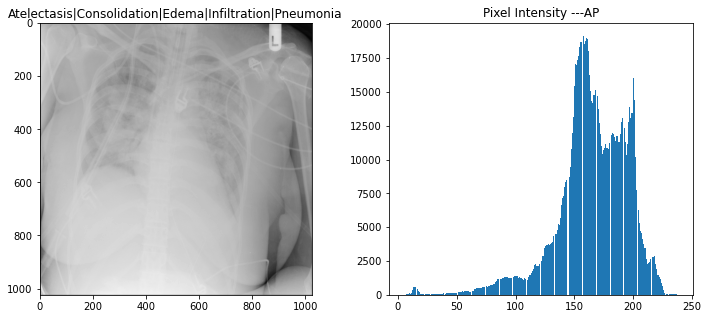

In [81]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize = (12, 5))
imgs_path_class = (sample_df.query('Pneumonia ==1  ')[['path','Finding Labels', 'View Position']]).sample(1)
sample_img1 = imgs_path_class.path.values[0]
img1 = imread(sample_img1)
ax0.imshow(img1,cmap='gray')
ax0.set_title(imgs_path_class["Finding Labels"].values[0] )
ax1.hist(img1.ravel(),bins=255)
ax1.set_title("Pixel Intensity " + '---' + imgs_path_class["View Position"].values[0]) 
plt.show()



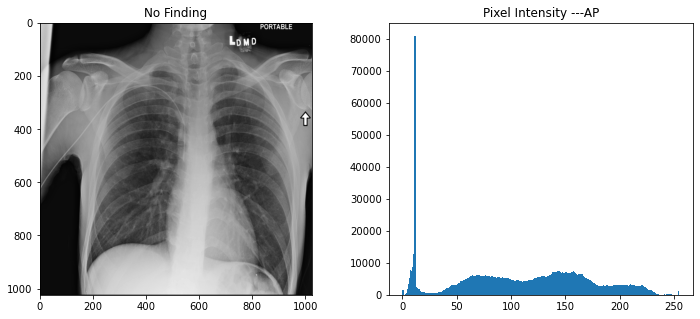

In [85]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize = (12, 5))
imgs_path_class = (sample_df.query('Pneumonia ==0 & `Finding Labels` =="No Finding" ')[['path','Finding Labels', 'View Position']]).sample(1)
sample_img1 = imgs_path_class.path.values[0]
img1 = imread(sample_img1)
ax0.imshow(img1,cmap='gray')
ax0.set_title(imgs_path_class["Finding Labels"].values[0] )
ax1.hist(img1.ravel(),bins=255)
ax1.set_title("Pixel Intensity " + '---' + imgs_path_class["View Position"].values[0]) 
plt.show()


In [67]:
sample_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [8]:
img_intensity = []
img_path = sample_df['path']

for path in img_path:
    img = imread(path)
    img_intensity.append(np.mean(img)) 
    
img_intensity = np.array(img_intensity)


In [9]:
img_intensity.shape

(5606,)

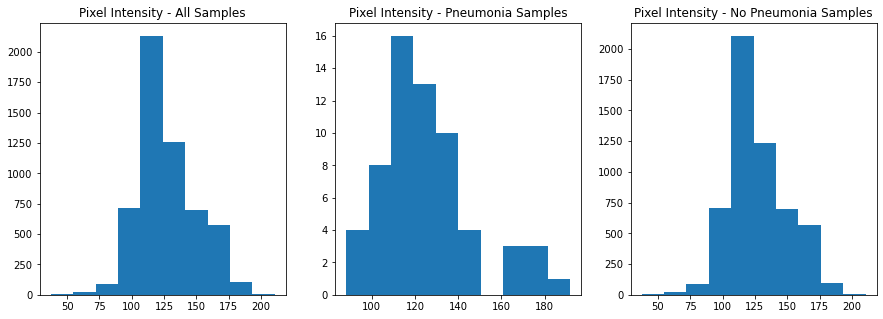

In [10]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize = (15, 5))

ax0.hist(img_intensity)
ax0.set_title("Pixel Intensity - All Samples")
pneumonia_intensity = img_intensity[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]

ax1.hist(pneumonia_intensity)
ax1.set_title("Pixel Intensity - Pneumonia Samples")

no_pneumonia_intensity = img_intensity[sample_df[~sample_df["Finding Labels"].str.contains("Pneumonia")].index]
ax2.hist(no_pneumonia_intensity)
ax2.set_title("Pixel Intensity - No Pneumonia Samples")

plt.show()

As expected, the intensity charts for all samples and negative for pneumonia are similiar as the majority of the population does not have pneumonia. They both seem to peak around the same intensity level 120.
The pneumonia chart has a lower peak of intensity around 115. 

### Conclusion

* There is a small percentage of records with patient more than 150 years. I think that we can remove these from our training set.
* In exploring the data distribution, it seems that  distributions of Age and Gender are similiar in ratios in general population compared to pneumonia cases. View postion is, however, reversed such that general population is dominated with PA scans, and pneumonia has more AP scans. This is interesting as PA is the "Gold Standard" for chest X-rays (https://www.elearning.isrrt.org/mod/book/tool/print/index.php?id=321). Perhaps, there are pneumonia patients are not able to position themselves for a PA scanning.
* The full dataset has 112120 records. There are  1431 findings of pneumonia which is only 1.28% of the whole population
  * Need to balance the training dataset 50/50 of non-pneumonia and pneumonia cases, so the alogirthm has a balanced learing of both classes.
  * Use Keras ImageDataGenerator to create additional featured images to help with deep learning process.
* The peak intensity of the pneumonia images (115) seems to be lower than of general population (120).
* With large amount of data (images), GPU platform is necessary to train the data for faster performance.
